In [1]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

2.1.2
11.8
True
1
0


In [3]:
method = ''
from g2g_model_Fisher import *

In [13]:
model_name = 'saddle'
result_path = 'results/'+model_name+'/'
figure_path = 'figures/'
cmap = plt.colormaps['Spectral_r']

In [5]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path) 

In [6]:
# Define the double well potential function
def saddle_potential(x1, x2):
    return 1*((x1)**2 - (x2)**2)

# Define the range of x and y values to plot


x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

# Create a 2D grid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the potential energy at each point in the grid
Z = saddle_potential(X, Y)

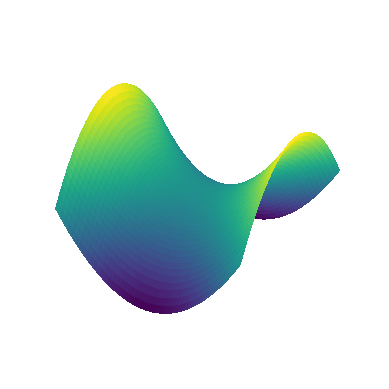

In [7]:
# Create a 3D surface plot of the potential energy
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=False)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.set_xlabel('X',fontsize=20,weight='bold')
# ax.set_ylabel('Y',fontsize=20,weight='bold')
# ax.set_zlabel('Z',fontsize=20,weight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')

plt.savefig(result_path+model_name+'.png',dpi=600,bbox_inches='tight')
plt.show()

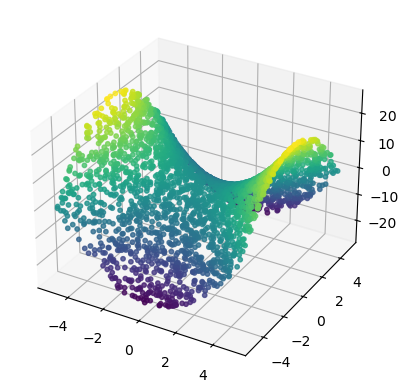

In [8]:
#-------saddle-----------

n_samples=3000
X_minor=0.1*np.random.randn(n_samples,7)

roi=np.linspace(-5,5,10000)

x1=np.random.choice(roi,n_samples)
x2=np.random.choice(roi,n_samples)
color_label=np.zeros((n_samples))
color_label[np.argsort(x2)]=np.arange(n_samples)

x3=1*((x1)**2 - (x2)**2)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
ax.scatter(x1, x2, x3,  s=10, c=x3,alpha=0.8,cmap='viridis')
plt.show()

X_major=np.array([x1,x2,x3]).T
X=np.hstack((X_major,X_minor))

In [9]:
k_nei = 10
A = kneighbors_graph(X, k_nei, mode='connectivity', include_self=True)
# A=radius_neighbors_graph(X,3,include_self=True)
X_major = X[:,:3]

row =np.array([np.ones((k_nei,))*i for i in range(n_samples)]).flatten()
col=A.indices
w_val=np.array([np.linalg.norm(X_major[int(i),:]-X_major[int(j),:]) for i,j in zip(row,col)])
dc=np.mean(w_val)

cell_nei=A.indices.reshape(X.shape[0],10)
nei_w=[]
rho_arr=[]
for ni in cell_nei:
    dij=np.array([np.linalg.norm(X_major[int(ni[0]),:]-X_major[int(i),:]) for i in ni[1:]])
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

# plt.scatter(X_pca[:,0],X_pca[:,1],s=5,c=rho_arr,cmap=plt.cm.jet)
# plt.colorbar()
# plt.show()

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

In [10]:
epochs = 200
nsamples = 3
learning_rate = 1e-3
# n_workers = 4
K = 2
L = 3
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset

In [11]:
for i in range(10):
    reset_seeds(i)
    A=A.astype(np.float32)
    X=X.astype(np.float32)
    z=color_label

    n = A.shape[0]
    train_nodes, val_nodes = train_test_split(n, train_ratio=1)
    A_train = A[train_nodes, :][:, train_nodes]
    X_train = X[train_nodes]
    z_train = z[train_nodes]
    A_val = A[val_nodes, :][:, val_nodes]
    X_val = X[val_nodes]
    z_val = z[val_nodes]

    train_data = AttributedGraph(A_train, X_train, z_train, K)
    val_data = AttributedGraph(A_val, X_val, z_val, K)
    
    encoder = Encoder(X.shape[1], L)
    optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    iterations = epochs #// n_workers
    dataset = GraphDataset(train_data, nsamples, iterations)
    loader = DataLoader(
        dataset,
        batch_size=1,
        #num_workers=n_workers,
        worker_init_fn=reset_seeds,
        collate_fn=lambda args: args,
    )
    
    for batch_idx, data in enumerate(loader):
        encoder.train()
        optimizer.zero_grad()

        loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
        if batch_idx% 10 == 0:
            print(batch_idx,loss)
        loss.backward()
        optimizer.step()
        
    torch.save(encoder,result_path+'encoder'+str(i)+'.pt')
    
    mu, sigma = encoder(torch.FloatTensor(X))
    X_mu = mu.detach().numpy()
    X_sigma = sigma.detach().numpy()#The learned sigma is variance

#     cRc_arr=[]
    cRc_arr_eu=[]
#     cRc_arr_mueu=[]
    mu_learned = X_mu
    sigma_learned = X_sigma

    for inds in np.split(A.indices, A.indptr)[1:-1]:
        self_ind=inds[0]
#         cRc=0
        cRc_eu=0
#         cRc_mueu=0
        for nei_k in range(1,len(inds)):
            dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
#             dMuEu=np.linalg.norm(X_mu[self_ind,:]-X_mu[inds[nei_k],:])
#             dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
#                             mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
            dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                            mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

#             cRc += 1-dWa/dFi
            cRc_eu += 1-dWa/dEu
#             cRc_mueu += 1-dWa/dMuEu

#         cRc_arr.append(cRc/len(inds))
        cRc_arr_eu.append(cRc_eu/len(inds))
#         cRc_arr_mueu.append(cRc_mueu/len(inds))
#     orc = np.array(cRc_arr)
    orc_eu = np.array(cRc_arr_eu)
#     orc_mueu = np.array(cRc_arr_mueu)
    
    np.save(result_path+'crc'+str(i),orc_eu)

0 tensor(2.6384e+08, grad_fn=<DivBackward0>)
10 tensor(47091172., grad_fn=<DivBackward0>)
20 tensor(40195296., grad_fn=<DivBackward0>)
30 tensor(37641676., grad_fn=<DivBackward0>)
40 tensor(36904828., grad_fn=<DivBackward0>)
50 tensor(35970028., grad_fn=<DivBackward0>)
60 tensor(34041884., grad_fn=<DivBackward0>)
70 tensor(34191488., grad_fn=<DivBackward0>)
80 tensor(33559276., grad_fn=<DivBackward0>)
90 tensor(32437040., grad_fn=<DivBackward0>)
100 tensor(32666066., grad_fn=<DivBackward0>)
110 tensor(31478528., grad_fn=<DivBackward0>)
120 tensor(31724838., grad_fn=<DivBackward0>)
130 tensor(32082266., grad_fn=<DivBackward0>)
140 tensor(31495230., grad_fn=<DivBackward0>)
150 tensor(31402640., grad_fn=<DivBackward0>)
160 tensor(31618698., grad_fn=<DivBackward0>)
170 tensor(30779952., grad_fn=<DivBackward0>)
180 tensor(30765526., grad_fn=<DivBackward0>)
190 tensor(30621616., grad_fn=<DivBackward0>)
0 tensor(71409960., grad_fn=<DivBackward0>)
10 tensor(39428484., grad_fn=<DivBackward0>)
2

In [14]:
encoders = [0]*10
mus = [0]*10
sgms = [0]*10
crcs_smooth = [0]*10
for i in range(10):
    encoders[i] = torch.load(result_path+'encoder'+str(i)+'.pt')
    mu, sigma = encoders[i](torch.FloatTensor(X))
    mus[i] = mu.detach().numpy()
    sgms[i] = sigma.detach().numpy()
    crcs_smooth[i] = smooth_func(np.load(result_path+'crc'+str(i)+'.npy'))
encoders = np.array(encoders)
mus = np.array(mus)
sgms = np.array(sgms)
crcs_smooth = np.array(crcs_smooth)

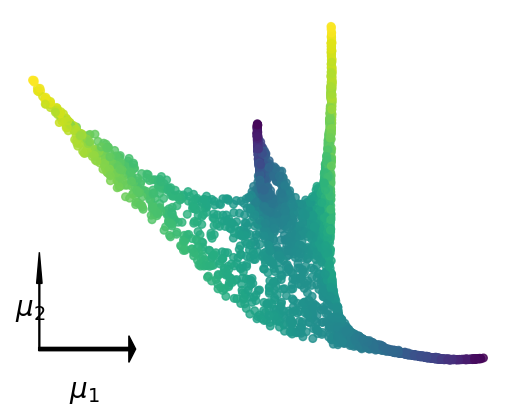

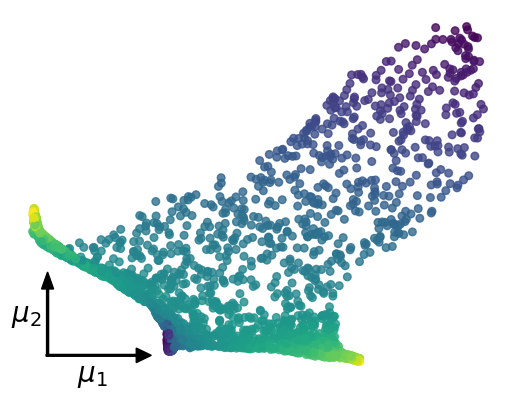

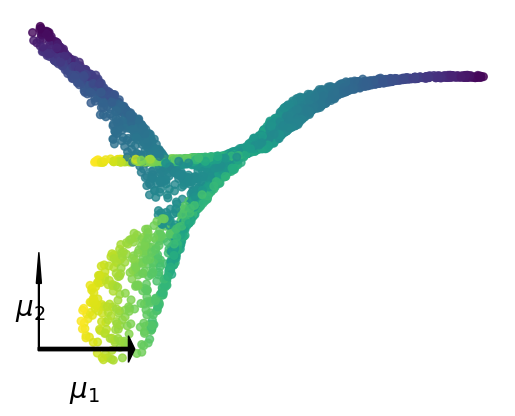

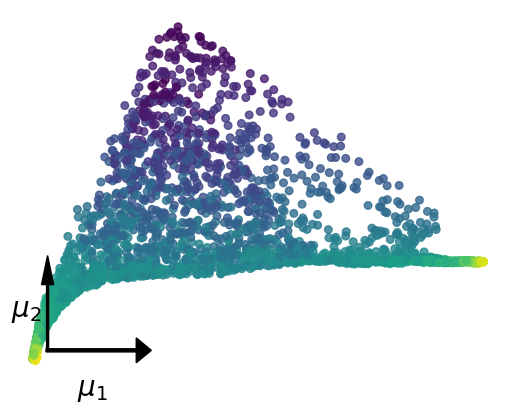

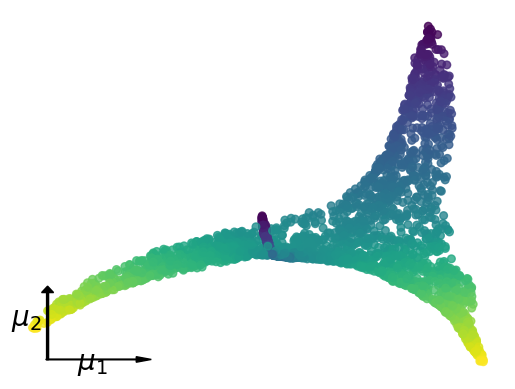

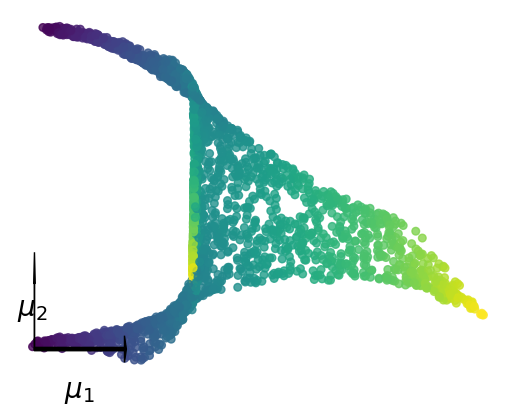

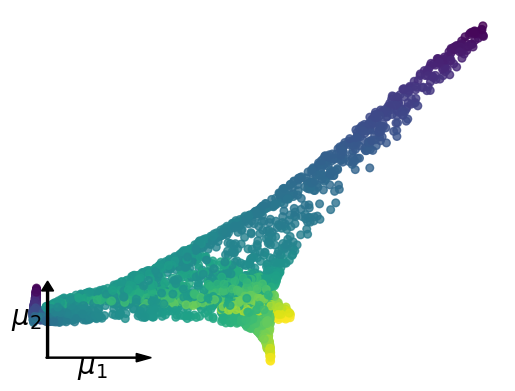

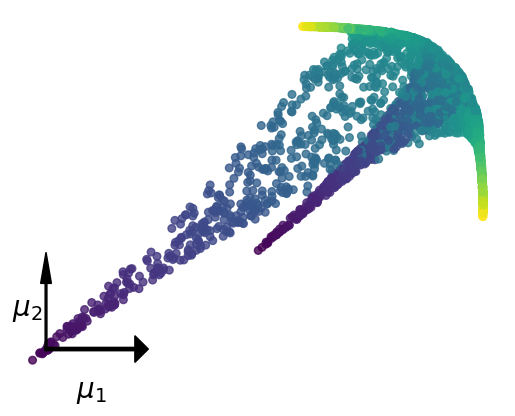

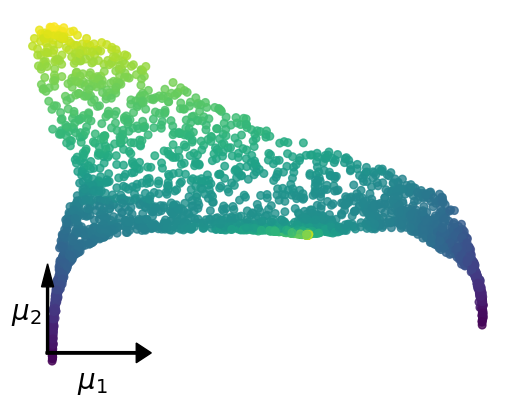

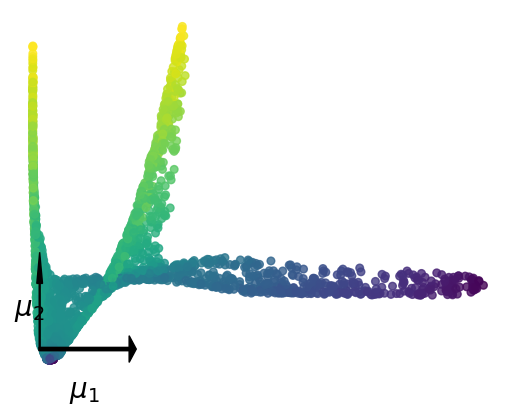

In [18]:
for n10 in range(10):
    X_plt = mus[n10,:,0]
    Y_plt = mus[n10,:,1]
    X_min = np.min(X_plt)
    X_max = np.max(X_plt)
    Y_min = np.min(Y_plt)
    Y_max = np.max(Y_plt)
    X_len = (X_max-X_min)/5
    Y_len = (Y_max-Y_min)/5
    wid = min(X_len,Y_len)/30
    X_ori = X_min+5*wid
    Y_ori = Y_min+5*wid
    
    plt.scatter(X_plt,Y_plt,s=30,alpha=0.8,c=X[:,2],cmap='viridis')
    plt.axis('off')
    
    plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid*1.5,color='black',head_width=12*wid,head_length=5*wid)
    plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid*2/3,color='black',head_width=4*wid,head_length=14*wid)
    
    plt.text(X_ori+X_len/2,Y_ori-wid*22,'$\mu_1$',fontsize=20,ha='center',weight='bold')
    plt.text(X_ori-wid*7,Y_ori+Y_len/2,'$\mu_2$',fontsize=20,ha='center',weight='bold')
    
    # plt.savefig(result_path+model_name+'_mu.png',dpi=600,bbox_inches='tight')
    plt.show()

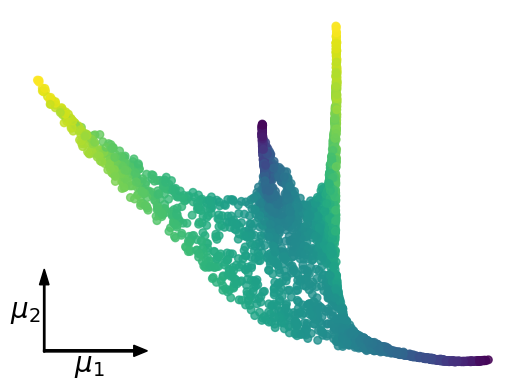

In [27]:
n10 = 0
X_plt = mus[n10,:,0]
Y_plt = mus[n10,:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min+5*wid
Y_ori = Y_min+5*wid

plt.scatter(X_plt,Y_plt,s=30,alpha=0.8,c=X[:,2],cmap='viridis')
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid,head_length=10*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=7*wid,head_length=7*wid)

plt.text(X_ori+X_len/2,Y_ori-wid*9,'$\mu_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*14,Y_ori+Y_len/2,'$\mu_2$',fontsize=20,ha='center',weight='bold')

plt.savefig(figure_path+'2b1.png',dpi=600,bbox_inches='tight')
plt.show()

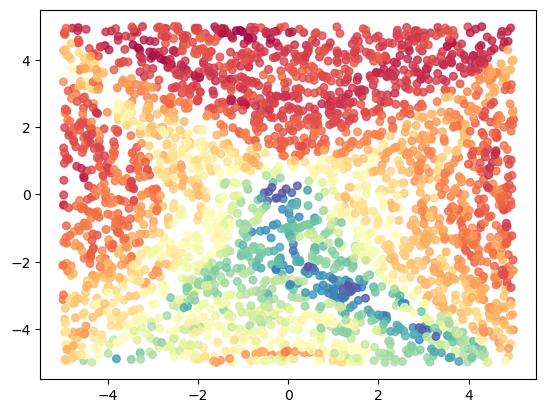

In [28]:
plt.scatter(
    X[:, 0], X[:, 1], c=crcs_smooth[6,:], s=30, alpha=0.8,cmap=cmap
    # X[:, 0], X[:, 1], c=np.mean(crcs_smooth,axis=0), s=30, alpha=0.8,cmap=cmap
)
plt.show()